Testing out Code ...

In [ ]:
!jupyter nbconvert --to script /content/EDA_extension.ipynb


[NbConvertApp] WARNING | pattern '/content/EDA_extension.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/'UTBIOME KNEE MODEL'


dataset		     EDA_gait.ipynb    KneE_PAD_Download_Read_and_Segment.ipynb
EDA_extension.ipynb  EDA_squats.ipynb  README.md


In [ ]:
!unzip -q "/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset.zip" -d "/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset"


unzip:  cannot find or open /content/drive/MyDrive/UTBIOME KNEE MODEL/dataset.zip, /content/drive/MyDrive/UTBIOME KNEE MODEL/dataset.zip.zip or /content/drive/MyDrive/UTBIOME KNEE MODEL/dataset.zip.ZIP.


In [ ]:
!ls "/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset"


Subject_1   Subject_15	Subject_20  Subject_26	Subject_31  Subject_9
Subject_10  Subject_16	Subject_21  Subject_27	Subject_4
Subject_11  Subject_17	Subject_22  Subject_28	Subject_5
Subject_12  Subject_18	Subject_23  Subject_29	Subject_6
Subject_13  Subject_19	Subject_24  Subject_3	Subject_7
Subject_14  Subject_2	Subject_25  Subject_30	Subject_8


In [ ]:
from pathlib import Path
import numpy as np

# Root folder of your dataset in Drive
DATA_DIR = Path("/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset")

# Recursively list all files in the dataset and print first 50
all_files = list(DATA_DIR.rglob("*"))
print("Total files found:", len(all_files))
for f in all_files[:50]:
    print(f)

# Filter for EMG files specifically
emg_files = [f for f in all_files if f.name.lower() == "emg.npy"]
print("\nFound EMG files:", len(emg_files))
for f in emg_files:
    print(f)
    emg = np.load(f)
    print("Shape:", emg.shape)


Total files found: 6538
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_15
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_23
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_25
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_22
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_13
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_12
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_24
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_14
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_3
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_4
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_18
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_2
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_30
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_29
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_31
/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/Subject_11
/co

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

###Preprocessed data in the form of numpy files

In [ ]:
import os
import numpy as np
from skimage.util import view_as_windows
import scipy.signal
import matplotlib.pyplot as plt

In [ ]:
def hipass_filter(data, sampling_frequency, cutoff, order):
    cutoff = cutoff/(sampling_frequency/2)
    assert cutoff < 1 # cutoff given too high for nyquist rate
    installed_filter_b, installed_filter_a = scipy.signal.butter(N=order,Wn=cutoff,btype="highpass")

    filtered_data = scipy.signal.filtfilt(installed_filter_b,
                                            installed_filter_a,
                                            data.T,
                                            axis=0)
    return filtered_data.T

In [ ]:
path = 'dataset/'
window = 4 #seconds
emg_sr = 1259.2592592592594 #Hz
imu_sr = 148.14814814814815 #Hz
window_step = 1/4 #0.25sec
n_sensors = 8
cutoff = 50
order = 2

In [ ]:
counter = 0
fcounter = 0
tduration = 0

path = "/content/drive/MyDrive/UTBIOME KNEE MODEL/dataset/"

for sub in os.listdir(path):
    print(sub)
    s = int(''.join([s for s in [*sub] if s.isdigit()]))
    for act in os.listdir(path+sub):
        for tr in os.listdir(path+sub+'/'+act):
            fcounter+=1
            emg = np.load(path+sub+'/'+act+'/'+tr+'/'+'emg.npy')
            imu = np.load(path+sub+'/'+act+'/'+tr+'/'+'imu.npy')
            duration = emg.shape[1]/emg_sr
            tduration += duration
            if int(act)>5:
                # avoid having several walking examples we use a larger stride
                window_step = 1/2
            else:
                window_step = 1/4

            if duration<=0:
                continue
            elif duration<window:
                emg_segments = np.zeros((1,n_sensors,int(np.round(window*emg_sr))))
                emg_segments[:,:,:emg.shape[1]] = emg

                imu_segments = np.zeros((1,6*n_sensors,int(np.round(window*imu_sr))))
                imu_segments[:,:,:imu.shape[1]] = imu
            else:
                emg_segments = view_as_windows(np.array(emg), window_shape=(n_sensors,int(np.round(window*emg_sr))),
                                        step=int(emg_sr*window_step))[0]

                imu_segments = view_as_windows(np.array(imu), window_shape=(6*n_sensors,int(np.round(window*imu_sr))),
                                        step=int(imu_sr*window_step))[0]

            ### Check if EMG shape matches the IMU shape!
            assert len(emg_segments)==len(imu_segments)
            counter+=len(emg_segments)

Subject_15
Subject_23
Subject_25
Subject_22
Subject_13
Subject_12
Subject_24
Subject_14
Subject_3
Subject_4
Subject_18
Subject_2
Subject_30
Subject_29
Subject_31
Subject_11
Subject_5
Subject_27
Subject_20
Subject_16
Subject_17
Subject_21
Subject_19
Subject_28
Subject_7
Subject_10
Subject_26
Subject_9
Subject_8
Subject_6
Subject_1


In [ ]:
print('Average duration:', tduration/fcounter)
print('Total duration:', tduration)
print('Total amount of files:', fcounter)
print('Total amount of segmented files:', counter)
print('Total EMG values:', tduration*n_sensors*emg_sr)
print('Total IMU values:', tduration*n_sensors*imu_sr*6)

Average duration: 4.175805594721084
Total duration: 8710.730470588182
Total amount of files: 2086
Total amount of segmented files: 4833
Total EMG values: 87752543.99999946
Total IMU values: 61942972.235293746


In [ ]:
# instatiate two tensors with zeros to be filled later with IMU and EMG segments
global_emg_segments = np.zeros((counter,n_sensors,int(window*emg_sr)))
global_imu_segments = np.zeros((counter,6*n_sensors,int(np.round(window*imu_sr))))

subjects = []
labels = []
sessions = []
current_seg_id = 0

for sub in os.listdir(path):
    print(sub)
    s = int(''.join([s for s in [*sub] if s.isdigit()]))
    for act in os.listdir(path+sub):
        for tr in os.listdir(path+sub+'/'+act):
            emg = np.load(path+sub+'/'+act+'/'+tr+'/'+'emg.npy')
            #emg = bp_filter(emg_sr,emg)
            imu = np.load(path+sub+'/'+act+'/'+tr+'/'+'imu.npy')
            duration = emg.shape[1]/emg_sr
            if int(act)>5:
                # avoid having several walking examples we use a larger stride
                window_step = 1/2
            else:
                window_step = 1/4
            if duration<=0:
                continue
            elif duration<window:
                emg = np.clip(hipass_filter(emg,emg_sr,cutoff,order),a_min=-0.3,a_max=0.3)
#                 emg = np.clip(bp_filter(emg_sr,emg),a_min=-0.3,a_max=0.3)
                emg_segments = np.zeros((1,n_sensors,int(np.round(window*emg_sr))))
                emg_segments[:,:,:emg.shape[1]] = emg

                imu_segments = np.ones((1,6*n_sensors,int(np.round(window*imu_sr))))
                imu_segments = imu_segments*np.expand_dims(imu[:,-1],-1)
                imu_segments[:,:,:imu.shape[1]] = imu
            else:
                emg = np.clip(hipass_filter(emg,emg_sr,cutoff,order),a_min=-0.3,a_max=0.3)
                emg_segments = view_as_windows(np.array(emg), window_shape=(n_sensors,int(np.round(window*emg_sr))),
                                        step=int(emg_sr*window_step))[0]

                imu_segments = view_as_windows(np.array(imu), window_shape=(6*n_sensors,int(np.round(window*imu_sr))),
                                        step=int(imu_sr*window_step))[0]

            next_seg_id = current_seg_id + len(emg_segments)
            global_emg_segments[current_seg_id:next_seg_id,:,:] = emg_segments
            global_imu_segments[current_seg_id:next_seg_id,:,:] = imu_segments

            subjects+=[s]*len(emg_segments)
            labels+=[int(act)]*len(emg_segments)
            sessions+=[path+sub+'/'+act+'/'+tr]*len(emg_segments)

            current_seg_id += len(emg_segments)

Subject_15
Subject_23
Subject_25
Subject_22
Subject_13
Subject_12
Subject_24
Subject_14
Subject_3
Subject_4
Subject_18
Subject_2
Subject_30
Subject_29
Subject_31
Subject_11
Subject_5
Subject_27
Subject_20
Subject_16
Subject_17
Subject_21
Subject_19
Subject_28
Subject_7
Subject_10
Subject_26
Subject_9
Subject_8
Subject_6
Subject_1


In [ ]:
assert global_emg_segments.shape[0]==global_imu_segments.shape[0]

In [ ]:
emg = global_emg_segments
imu = global_imu_segments

labels = np.array(labels)
subjects = np.array(subjects)
sessions = np.array(sessions)

In [ ]:
np.save('emg_all.npy',emg)
np.save('imu_all.npy',imu)
np.save('labels_all.npy',labels)
np.save('subjects_all.npy',subjects)
np.save('sessions_all.npy',sessions)

Purpose: Saving in MATLAB format

In [ ]:
from scipy.io import savemat

# save the whole dataset in .mat
dataset_dict = {'emg':emg, 'imu':imu, 'labels':labels, 'subjects':subjects, 'trials':sessions}
savemat('dataset.mat', dataset_dict)

###Rolling RMS

In [ ]:
def rolling_rms(x, N):
    xc = np.cumsum(abs(np.array(x))**2)
    return np.sqrt((xc[N:] - xc[:-N]) / N)

In [ ]:
N = 200

rms_emg = np.zeros((emg.shape[0],emg.shape[1],emg.shape[2]-N))
for i in range(len(rms_emg)):
    for j in range(8):
        rms_emg[i,j,:] = rolling_rms(emg[i,j,:],N)

In [ ]:
left = [1,  2,  3,  6,  7, 12, 16, 17, 18, 20, 21, 23, 24, 27, 30] #1
right = [4,  5,  8,  9, 10, 11, 13, 14, 15, 19, 20, 21, 22, 25, 26, 28, 29, 31] #0

In [ ]:
foot = np.zeros(len(subjects),dtype=int)
strong_foot = np.zeros(len(subjects),dtype=int)
i_foot = []
h_foot = []
for i in range(len(subjects)):
    if subjects[i] in right:
        foot[i] = 0
        strong_foot[i] = 4
        i_foot.append('right')
        h_foot.append('left')
    else:
        foot[i] = 4
        strong_foot[i] = 0
        i_foot.append('left')
        h_foot.append('right')

subject: 15
activity: 3


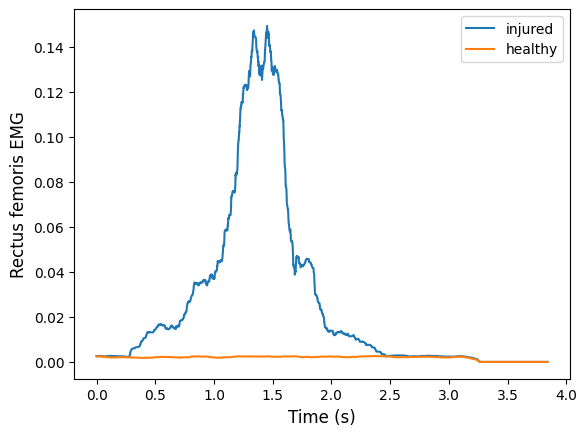

In [ ]:
ind = 108
print('subject:',subjects[108])
print('activity:',labels[ind])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[108],:])
plt.plot(time,rms_emg[ind,strong_foot[108],:])
plt.legend(["injured", "healthy"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Rectus femoris EMG', fontsize=12)

plt.savefig('Rectus_femoris_EMG_squat.png', dpi=300)

plt.show()

subject: 20
activity: 0


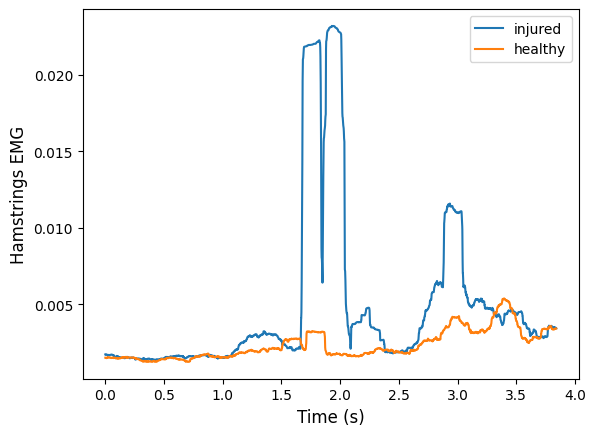

In [ ]:
ind = 2675
print('subject:',subjects[ind])
print('activity:',labels[ind])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[108]+1,:])
plt.plot(time,rms_emg[ind,strong_foot[108]+1,:])
plt.legend(["injured", "healthy"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Hamstrings EMG', fontsize=12)

plt.savefig('hamstrings_EMG_squat.png', dpi=300)

plt.show()

subject: 27
activity: 0 0 6


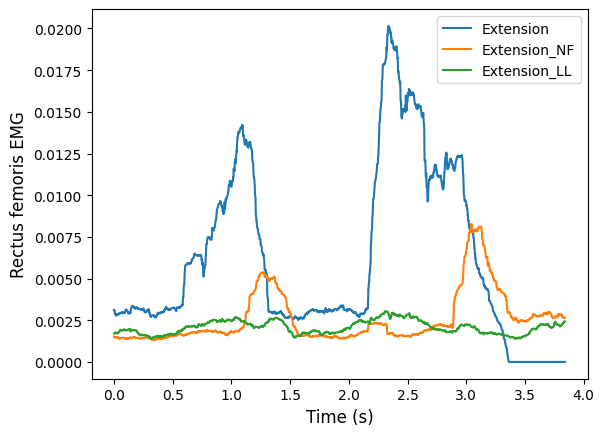

In [ ]:
ind = 2490
ind_2 = 3640
ind_3 = 3840
print('subject:',subjects[ind])
print('activity:',labels[ind], labels[ind_2], labels[ind_3])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[ind]+0,:])
plt.plot(time,rms_emg[ind_2,foot[ind_2]+0,:])
plt.plot(time,rms_emg[ind_3,foot[ind_3]+0,:])
plt.legend(["Extension", "Extension_NF", "Extension_LL"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Rectus femoris EMG', fontsize=12)

plt.savefig('rectus_femoris_EMG_extension.png', dpi=300)

plt.show()

subject: 7
activity: 1 7 6


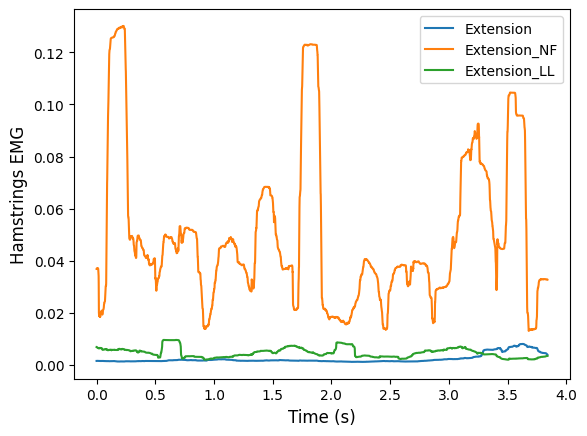

In [ ]:
ind = 3784
ind_2 = 3698
ind_3 = 3839
print('subject:',subjects[ind])
print('activity:',labels[ind], labels[ind_2], labels[ind_3])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[ind]+1,:])
plt.plot(time,rms_emg[ind_2,foot[ind_2]+1,:])
plt.plot(time,rms_emg[ind_3,foot[ind_3]+1,:])
plt.legend(["Extension", "Extension_NF", "Extension_LL"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Hamstrings EMG', fontsize=12)

plt.savefig('hamstrings_EMG_extension.png', dpi=300)

plt.show()

subject: 28
activity: 6


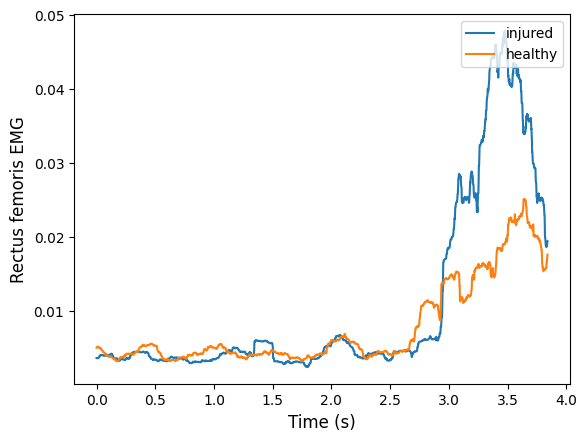

In [ ]:
ind = 3540

print('subject:',subjects[ind])
print('activity:',labels[ind])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[ind]+0,:])
plt.plot(time,rms_emg[ind,strong_foot[ind]+0,:])
plt.legend(["injured", "healthy"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Rectus femoris EMG', fontsize=12)

plt.savefig('Rectus_femoris_EMG_walking_nfe.png', dpi=300)

plt.show()

subject: 7
activity: 0


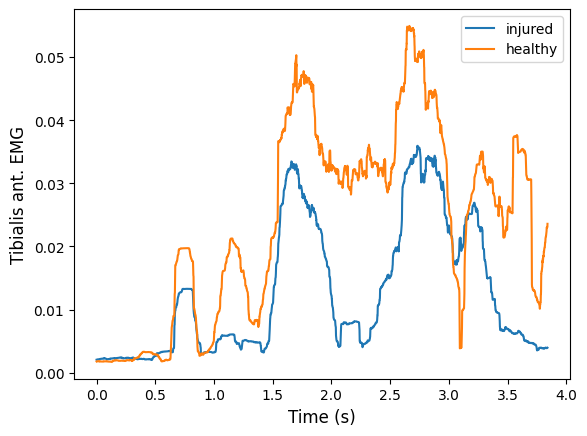

In [ ]:
ind = 3635
print('subject:',subjects[ind])
print('activity:',labels[ind])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[ind]+2,:])
plt.plot(time,rms_emg[ind,strong_foot[ind]+2,:])
plt.legend(["injured", "healthy"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Tibialis ant. EMG', fontsize=12)

plt.savefig('tibialis_ant._EMG.png', dpi=300)

plt.show()



# Extension


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
emg = np.load('emg_all.npy')
imu = np.load('imu_all.npy')
labels = np.load('labels_all.npy')
subjects = np.load('subjects_all.npy')
sessions = np.load('sessions_all.npy')

In [ ]:
emg = emg[(labels<6) & (labels>2)]
imu = imu[(labels<6) & (labels>2)]
subjects = subjects[(labels<6) & (labels>2)]
labels = labels[(labels<6) & (labels>2)]

In [ ]:
left = [1,  2,  3,  6,  7, 12, 16, 17, 18, 20, 21, 23, 24, 27, 30] #1
right = [4,  5,  8,  9, 10, 11, 13, 14, 15, 19, 20, 21, 22, 25, 26, 28, 29, 31] #0

In [ ]:
foot = np.zeros(len(subjects),dtype=int)
strong_foot = np.zeros(len(subjects),dtype=int)
i_foot = []
h_foot = []
for i in range(len(subjects)):
    if subjects[i] in right:
        foot[i] = 0
        strong_foot[i] = 4
        i_foot.append('right')
        h_foot.append('left')
    else:
        foot[i] = 4
        strong_foot[i] = 0
        i_foot.append('left')
        h_foot.append('right')

STD on hamstrings

/tmp/ipython-input-4135998819.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['activity'].replace({3: 'Extension', 4: 'Extension_NF', 5: 'Extension_LL',},inplace=True)


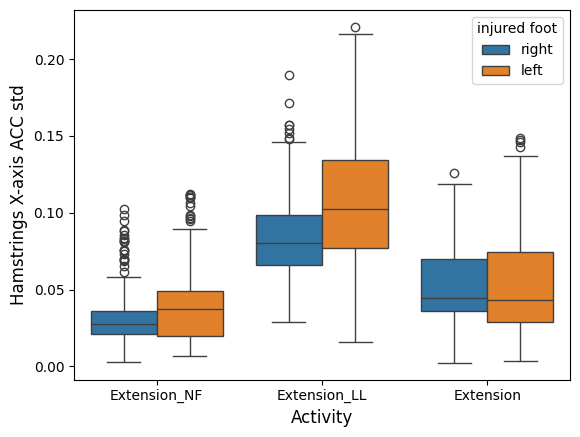

In [ ]:
stds_i = np.zeros(len(foot))
stds_h = np.zeros(len(strong_foot))
for i in range(len(foot)):
    stds_i[i] = np.std(imu[i,foot[i]*6+6,:])

df = pd.DataFrame({'std':stds_i,'injured foot':i_foot,
                  'activity':labels})
df['activity'].replace({3: 'Extension', 4: 'Extension_NF', 5: 'Extension_LL',},inplace=True)

g = sns.boxplot(data=df, x="activity",y='std',hue='injured foot',showfliers=True)

plt.xlabel('Activity', fontsize=12)
plt.ylabel('Hamstrings X-axis ACC std', fontsize=12)
plt.show()

g.figure.savefig('extension_X_axis_hamstrings_std.png',dpi=300)

### std on tibialis anterior Y-axis IMU


/tmp/ipython-input-1808493481.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['activity'].replace({3: 'Extension', 4: 'Extension_NF', 5: 'Extension_LL',},inplace=True)


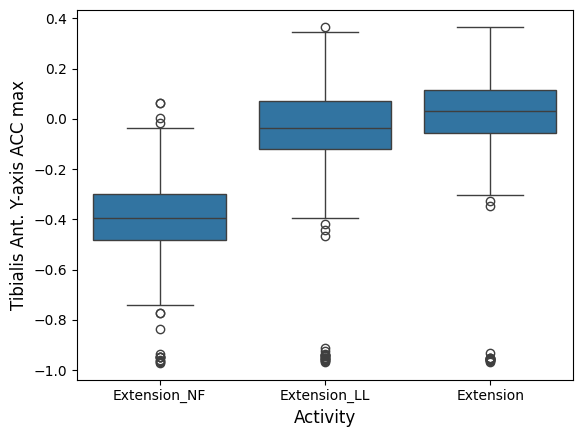

In [ ]:
maxs_i = np.zeros(len(foot))

for i in range(len(foot)):
    maxs_i[i] = np.max(imu[i,foot[i]*6+13,:])

df = pd.DataFrame({'max':maxs_i,
                  'activity':labels})
df['activity'].replace({3: 'Extension', 4: 'Extension_NF', 5: 'Extension_LL',},inplace=True)

g = sns.boxplot(data=df, x="activity",y='max',showfliers=True)

plt.xlabel('Activity', fontsize=12)
plt.ylabel('Tibialis Ant. Y-axis ACC max', fontsize=12)
plt.show()

g.figure.savefig('extension_Y_axis_tibialis_max.png',dpi=300)

### EMG activations


/tmp/ipython-input-3932635176.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['activity'].replace({3: 'Extension', 4: 'Extension_NF', 5: 'Extension_LL',},inplace=True)


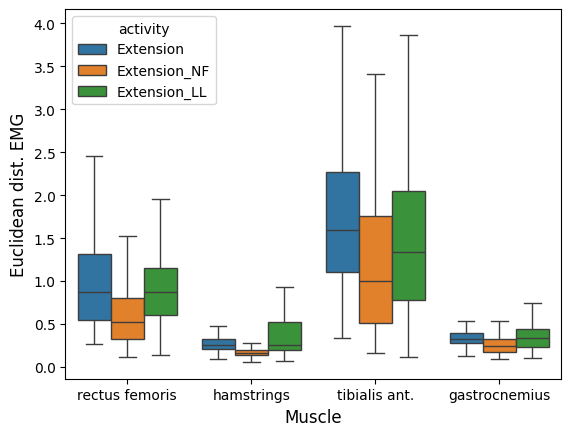

In [ ]:
dists = []
activities = []

for i in range(24):

    if i in [0,1,2,3]:
        ex = np.sqrt(np.sum(np.square(emg[np.where(labels==3)[0],i]-emg[np.where(labels==3)[0],i+4]),1))
        ex_nf = np.sqrt(np.sum(np.square(emg[np.where(labels==4)[0],i]-emg[np.where(labels==4)[0],i+4]),1))
        ex_ll = np.sqrt(np.sum(np.square(emg[np.where(labels==5)[0],i]-emg[np.where(labels==5)[0],i+4]),1))
    else:
        continue

    dist = list(np.concatenate([ex,ex_nf,ex_ll]))
    activity = list(np.concatenate([labels[labels==3],labels[labels==4],labels[labels==5]]))

    dists = dists+dist
    activities = activities+activity

muscles = ['rectus femoris']*len(labels) + ['hamstrings']*len(labels) + ['tibialis ant.']*len(labels) + ['gastrocnemius']*len(labels)


df = pd.DataFrame({'dist':dists, 'activity': activities,
                       'muscle':muscles})
df['activity'].replace({3: 'Extension', 4: 'Extension_NF', 5: 'Extension_LL',},inplace=True)

g=sns.boxplot(x="muscle", y="dist", hue="activity", data=df,showfliers=False)
plt.xlabel('Muscle', fontsize=12)
plt.ylabel('Euclidean dist. EMG', fontsize=12)
plt.show()

g.figure.savefig('extension_eucl_dist_EMG.png',dpi=300)

#gait

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
emg = np.load('emg_all.npy')
imu = np.load('imu_all.npy')
labels = np.load('labels_all.npy')
subjects = np.load('subjects_all.npy')
sessions = np.load('sessions_all.npy')

## EDA

In [ ]:
emg = emg[labels>=6]
imu = imu[labels>=6]
subjects = subjects[labels>=6]
labels = labels[labels>=6]

In [ ]:
left = [1,  2,  3,  6,  7, 12, 16, 17, 18, 20, 21, 23, 24, 27, 30] #1
right = [4,  5,  8,  9, 10, 11, 13, 14, 15, 19, 20, 21, 22, 25, 26, 28, 29, 31] #0

In [ ]:
foot = np.zeros(len(subjects),dtype=int)
strong_foot = np.zeros(len(subjects),dtype=int)
i_foot = []
h_foot = []
for i in range(len(subjects)):
    if subjects[i] in right:
        foot[i] = 0
        strong_foot[i] = 4
        i_foot.append('right')
        h_foot.append('left')
    else:
        foot[i] = 4
        strong_foot[i] = 0
        i_foot.append('left')
        h_foot.append('right')

### the std of normal gait is much higher than the other two for all IMUs, especially the gastrocnemius

/tmp/ipython-input-3887054895.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['activity'].replace({6: 'Gait', 7: 'Gait_NF', 8: 'Gait_HA',},inplace=True)


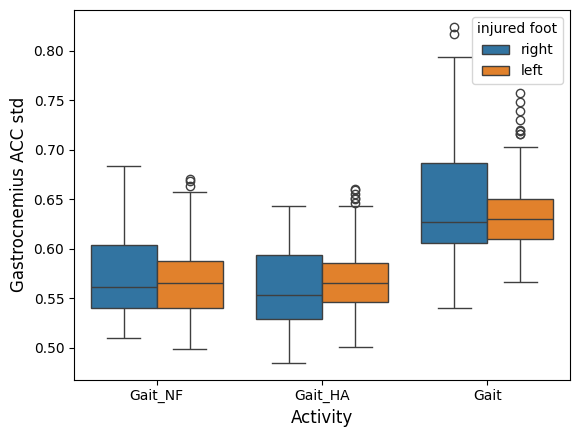

In [ ]:
stds_i = np.zeros(len(foot))
stds_h = np.zeros(len(strong_foot))
for i in range(len(foot)):
    stds_i[i] = np.std(imu[i,foot[i]*6+18:foot[i]*6+21,:])

df = pd.DataFrame({'std':stds_i,'injured foot':i_foot,
                  'activity':labels})
df['activity'].replace({6: 'Gait', 7: 'Gait_NF', 8: 'Gait_HA',},inplace=True)

g = sns.boxplot(data=df, x="activity",y='std',hue='injured foot',showfliers=True)

plt.xlabel('Activity', fontsize=12)
plt.ylabel('Gastrocnemius ACC std', fontsize=12)
plt.show()

g.figure.savefig('walking_std.png',dpi=300)

/tmp/ipython-input-2392965826.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['activity'].replace({6: 'Gait', 7: 'Gait_NF', 8: 'Gait_HA',},inplace=True)


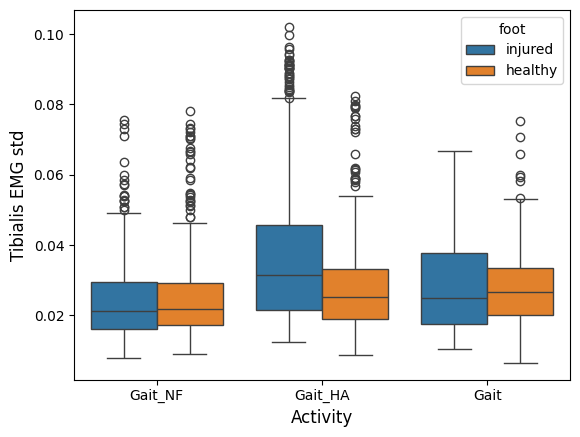

In [ ]:
stds_i = np.zeros(len(foot))
stds_h = np.zeros(len(strong_foot))
for i in range(len(foot)):
    stds_i[i] = np.std(emg[i,foot[i]+2,:])
    stds_h[i] = np.std(emg[i,strong_foot[i]+2,:])

df = pd.DataFrame({'std':np.concatenate([stds_i,stds_h]),'foot':['injured']*len(foot)+['healthy']*len(strong_foot),
                  'activity':np.concatenate([labels,labels])})
df['activity'].replace({6: 'Gait', 7: 'Gait_NF', 8: 'Gait_HA',},inplace=True)

g = sns.boxplot(data=df, x="activity",y='std',hue='foot',showfliers=True)
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Tibialis EMG std', fontsize=12)
plt.show()

g.figure.savefig('walking_ha_emg_tibialis.png',dpi=300)

In [ ]:
import scipy
from scipy.stats import skew, kurtosis

/tmp/ipython-input-161851500.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['activity'].replace({6: 'Gait', 7: 'Gait_NF', 8: 'Gait_HA',},inplace=True)


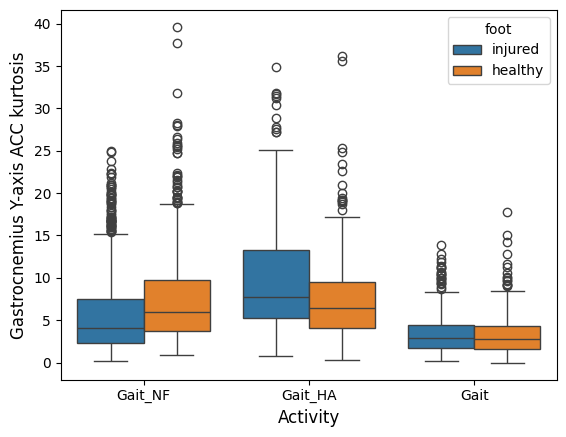

In [ ]:
kurt_i = np.zeros(len(foot))
kurt_h = np.zeros(len(strong_foot))
for i in range(len(foot)):
    kurt_i[i] = kurtosis(imu[i,foot[i]*6+13,:])
    kurt_h[i] = kurtosis(imu[i,strong_foot[i]*6+13,:])

df = pd.DataFrame({'std':np.concatenate([kurt_i,kurt_h]),'foot':['injured']*len(foot)+['healthy']*len(strong_foot),
                  'activity':np.concatenate([labels,labels])})
df['activity'].replace({6: 'Gait', 7: 'Gait_NF', 8: 'Gait_HA',},inplace=True)

g = sns.boxplot(data=df, x="activity",y='std',hue='foot',showfliers=True)
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Gastrocnemius Y-axis ACC kurtosis', fontsize=12)
plt.show()

g.figure.savefig('walking_kurtosis.png',dpi=300)

now onto squats

In [ ]:
emg = np.load('emg_all.npy')
imu = np.load('imu_all.npy')
labels = np.load('labels_all.npy')
subjects = np.load('subjects_all.npy')
sessions = np.load('sessions_all.npy')

In [ ]:
emg = emg[labels<=2]
imu = imu[labels<=2]
subjects = subjects[labels<=2]
labels = labels[labels<=2]

In [ ]:
left = [1,  2,  3,  6,  7, 12, 16, 17, 18, 20, 21, 23, 24, 27, 30] #1
right = [4,  5,  8,  9, 10, 11, 13, 14, 15, 19, 20, 21, 22, 25, 26, 28, 29, 31] #0

In [ ]:
foot = np.zeros(len(subjects),dtype=int)
strong_foot = np.zeros(len(subjects),dtype=int)
i_foot = []
h_foot = []
for i in range(len(subjects)):
    if subjects[i] in right:
        foot[i] = 0
        strong_foot[i] = 4
        i_foot.append('right')
        h_foot.append('left')
    else:
        foot[i] = 4
        strong_foot[i] = 0
        i_foot.append('left')
        h_foot.append('right')

### EMG hamstrings high std for squat_fl


/tmp/ipython-input-206834049.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['activity'].replace({0: 'Squat', 1: 'Squat_WT', 2: 'Squat_FL',},inplace=True)


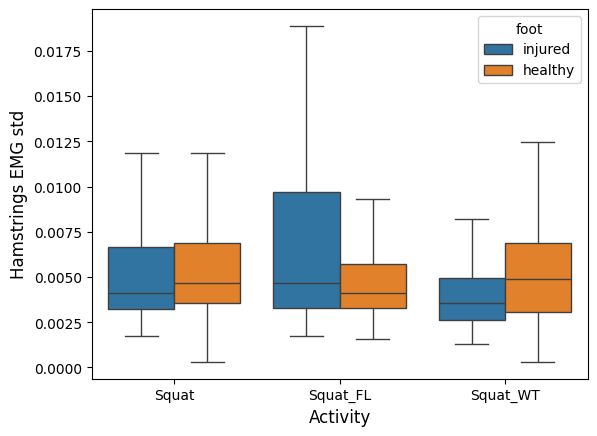

In [ ]:
stds_i = np.zeros(len(foot))
stds_h = np.zeros(len(strong_foot))
for i in range(len(foot)):
    stds_i[i] = np.std(emg[i,foot[i]+1,:])
    stds_h[i] = np.std(emg[i,strong_foot[i]+1,:])

df = pd.DataFrame({'std':np.concatenate([stds_i,stds_h]),'foot':['injured']*len(foot)+['healthy']*len(strong_foot),
                  'activity':np.concatenate([labels,labels])})

df['activity'].replace({0: 'Squat', 1: 'Squat_WT', 2: 'Squat_FL',},inplace=True)

g = sns.boxplot(data=df, x="activity",y='std',hue='foot',showfliers=False)
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Hamstrings EMG std', fontsize=12)
plt.show()

g.figure.savefig('squat_fl_emg_std_hamstrings.png',dpi=300)

### EMG rectus femoris high std for squat_wt

/tmp/ipython-input-3156421374.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['activity'].replace({0: 'Squat', 1: 'Squat_WT', 2: 'Squat_FL',},inplace=True)


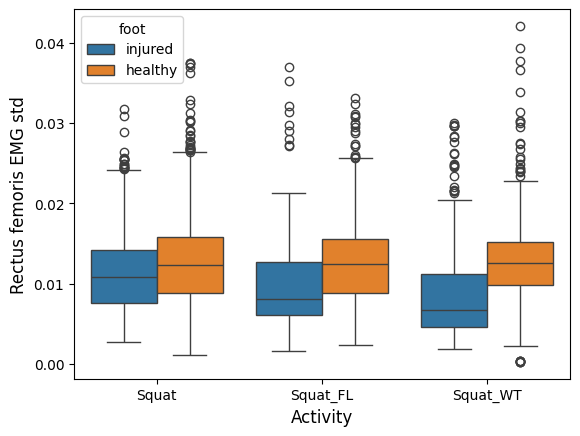

In [ ]:
stds_i = np.zeros(len(foot))
stds_h = np.zeros(len(strong_foot))
for i in range(len(foot)):
    stds_i[i] = np.std(emg[i,foot[i],:])
    stds_h[i] = np.std(emg[i,strong_foot[i],:])

df = pd.DataFrame({'std':np.concatenate([stds_i,stds_h]),'foot':['injured']*len(foot)+['healthy']*len(strong_foot),
                  'activity':np.concatenate([labels,labels])})
df['activity'].replace({0: 'Squat', 1: 'Squat_WT', 2: 'Squat_FL',},inplace=True)

g = sns.boxplot(data=df, x="activity",y='std',hue='foot',showfliers=True)
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Rectus femoris EMG std', fontsize=12)
plt.show()

g.figure.savefig('squat_wt_emg_std.png',dpi=300)

### Z-axis eucledian distance between the legs for all IMUs


/tmp/ipython-input-3235670345.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['activity'].replace({0: 'Squat', 1: 'Squat_WT', 2: 'Squat_FL',},inplace=True)


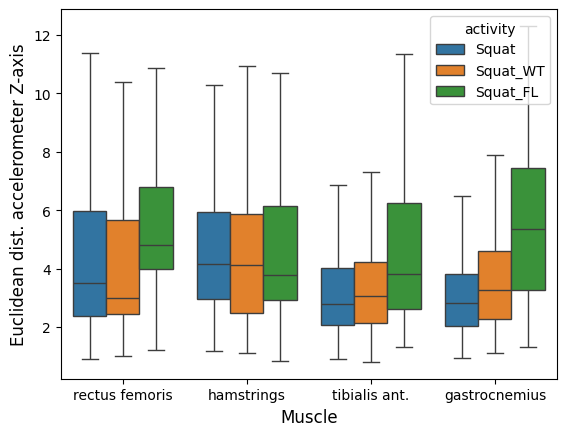

In [ ]:
dists = []
activities = []

for i in range(24):

    if i in [2,8,14,20]:
        sq = np.sqrt(np.sum(np.square(imu[np.where(labels==0)[0],i]-imu[np.where(labels==0)[0],i+24]),1))
        sq_emg = np.sqrt(np.sum(np.square(imu[np.where(labels==1)[0],i]-imu[np.where(labels==1)[0],i+24]),1))
        sq_fl = np.sqrt(np.sum(np.square(imu[np.where(labels==2)[0],i]-imu[np.where(labels==2)[0],i+24]),1))
    else:
        continue

    dist = list(np.concatenate([sq,sq_emg,sq_fl]))
    activity = list(np.concatenate([labels[labels==0],labels[labels==1],labels[labels==2]]))

    dists = dists+dist
    activities = activities+activity

muscles = ['rectus femoris']*len(labels) + ['hamstrings']*len(labels) + ['tibialis ant.']*len(labels) + ['gastrocnemius']*len(labels)


df = pd.DataFrame({'dist':dists, 'activity': activities,
                       'muscle':muscles})
df['activity'].replace({0: 'Squat', 1: 'Squat_WT', 2: 'Squat_FL',},inplace=True)

g=sns.boxplot(x="muscle", y="dist", hue="activity", data=df,showfliers=False)
plt.xlabel('Muscle', fontsize=12)
plt.ylabel('Euclidean dist. accelerometer Z-axis', fontsize=12)
plt.show()

g.figure.savefig('squat_eucl_dist_z_axis.png',dpi=300)